# Insightnest Vegetable Prices Analysis

<h1>Table of content<h1/>


<h1>Installing of required packages</h1>

In [2]:
pip install kagglehub # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [3]:
pip install ipywidgets # type: ignore

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


<h2>Data Extraction</h2>

<h3>Importing of Packages and global variables</h3>

In [4]:
import pandas as pd
import zipfile
import os
import tempfile
import shutil
import kagglehub
from price_cleaner import clean_veg_price_data
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

<h3>Extracting data into Dataframe</h3>

In [5]:
# 1. Download latest version of the dataset
zip_or_dir = kagglehub.dataset_download("ksamiksha19/vegetable-prices")
print("Downloaded to:", zip_or_dir)

# 2. Prepare a temp directory for extraction or reading
workdir = tempfile.mkdtemp(prefix="veg_prices_")

try:
    # 3. If it's a ZIP, extract; otherwise assume it's a directory
    if zipfile.is_zipfile(zip_or_dir):
        with zipfile.ZipFile(zip_or_dir, "r") as z:
            z.extractall(workdir)
    else:
        # copy all files into workdir
        for fname in os.listdir(zip_or_dir):
            shutil.copy(os.path.join(zip_or_dir, fname), workdir)

    # 4. Find all CSV files in workdir
    csv_files = [
        os.path.join(workdir, f)
        for f in os.listdir(workdir)
        if f.lower().endswith(".csv")
    ]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the dataset.")

    # 5. Read and concatenate into one DataFrame
    dfs = [pd.read_csv(f) for f in csv_files]
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(dfs)} file(s) into a single DataFrame with shape {df.shape}.")

    # 6. (Optional) quick preview
    print(df.head())

finally:
    # clean up temp folder
    shutil.rmtree(workdir)

Downloaded to: C:\Users\Bulelwa\.cache\kagglehub\datasets\ksamiksha19\vegetable-prices\versions\3
Loaded 1 file(s) into a single DataFrame with shape (287, 11).
  Price Dates  Bhindi (Ladies finger)  Tomato  Onion  Potato  Brinjal  Garlic  \
0  01-01-2023                    35.0      18   22.0      20       30      50   
1  02-01-2023                    35.0      16   22.0      20       30      55   
2  03-01-2023                    35.0      16   21.0      20       30      55   
3  04-01-2023                    30.0      16   21.0      22       25      55   
4  08-01-2023                    35.0      16   20.0      21       25      55   

   Peas  Methi  Green Chilli  Elephant Yam (Suran)  
0    25      8          45.0                    25  
1    25      7          40.0                    25  
2    25      7          40.0                    25  
3    25      7          40.0                    25  
4    22      6          35.0                    25  


## Preliminary Data Inspection

In [6]:
# Show structure and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price Dates             287 non-null    object 
 1   Bhindi (Ladies finger)  287 non-null    float64
 2   Tomato                  287 non-null    int64  
 3   Onion                   287 non-null    float64
 4   Potato                  287 non-null    int64  
 5   Brinjal                 287 non-null    int64  
 6   Garlic                  287 non-null    int64  
 7   Peas                    287 non-null    int64  
 8   Methi                   287 non-null    int64  
 9   Green Chilli            287 non-null    float64
 10  Elephant Yam (Suran)    287 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 24.8+ KB


In [7]:
# Describe empirical statistics
df.describe()

,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran)
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,29.444251,16.006969,20.649826,18.585366,31.655052,133.101045,66.658537,20.383275,44.122404,28.797909
std,8.124815,0.118056,11.711204,2.726238,11.725421,60.078331,33.302415,117.428417,12.796590,6.607973
min,17.000000,16.000000,8.000000,12.000000,14.000000,50.000000,22.000000,5.000000,0.130000,12.000000
25%,22.000000,16.000000,12.000000,16.000000,25.000000,85.000000,40.000000,8.000000,35.000000,25.000000
50%,27.500000,16.000000,16.000000,20.000000,30.000000,120.000000,60.000000,12.000000,40.000000,30.000000
75%,33.000000,16.000000,25.000000,20.000000,35.000000,165.000000,80.000000,16.000000,50.000000,30.000000
max,60.000000,18.000000,57.000000,24.000000,80.000000,290.000000,150.000000,2000.000000,90.000000,50.000000


## Data Cleaning and Tranformation


* Converted `Price Dates` to datetime format
  → Enables time-based analysis such as trend detection and seasonal grouping.

* Rounded all vegetable price columns to float with two decimal places
  → Ensures consistency in numeric formatting for better readability and computation.

* Handled non-numeric entries using `errors='coerce'`
  → Replaces invalid or missing price values with NaN, avoiding processing errors.

* Extracted `Month` from the date
  → Allows aggregation and filtering by calendar month.

* Derived `Season` from the month (Winter, Summer, Monsoon, Autumn)
  → Supports hypothesis testing and trend comparison across seasons.





In [8]:
# use the custom function to clean the data
df_cleaned = clean_veg_price_data(df)
#includes null or error converted
df_cleaned.isnull().sum()

Price Dates               0
Bhindi (Ladies finger)    0
Tomato                    0
Onion                     0
Potato                    0
Brinjal                   0
Garlic                    0
Peas                      0
Methi                     0
Green Chilli              0
Elephant Yam (Suran)      0
Month                     0
Season                    0
dtype: int64

In [9]:
#includes null or error converted
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Price Dates             287 non-null    datetime64[ns]
 1   Bhindi (Ladies finger)  287 non-null    float64       
 2   Tomato                  287 non-null    int64         
 3   Onion                   287 non-null    float64       
 4   Potato                  287 non-null    int64         
 5   Brinjal                 287 non-null    int64         
 6   Garlic                  287 non-null    int64         
 7   Peas                    287 non-null    int64         
 8   Methi                   287 non-null    int64         
 9   Green Chilli            287 non-null    float64       
 10  Elephant Yam (Suran)    287 non-null    int64         
 11  Month                   287 non-null    int32         
 12  Season                  287 non-null    object    

In [10]:
# Show the cleaned DataFrame
df_cleaned.head()

,Price Dates,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran),Month,Season
0,2023-01-01,35.0,18,22.0,20,30,50,25,8,45.0,25,1,Summer
1,2023-01-02,35.0,16,22.0,20,30,55,25,7,40.0,25,1,Summer
2,2023-01-03,35.0,16,21.0,20,30,55,25,7,40.0,25,1,Summer
3,2023-01-04,30.0,16,21.0,22,25,55,25,7,40.0,25,1,Summer
4,2023-01-08,35.0,16,20.0,21,25,55,22,6,35.0,25,1,Summer


In [11]:
df_cleaned.tail()

,Price Dates,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran),Month,Season
282,2023-12-27,45.0,16,30.0,20,70,260,40,16,40.0,25,12,Summer
283,2023-12-28,45.0,16,30.0,20,70,260,30,20,45.0,25,12,Summer
284,2023-12-29,45.0,16,30.0,22,80,260,30,18,50.0,25,12,Summer
285,2023-12-31,45.0,16,26.0,20,60,250,40,16,50.0,40,12,Summer
286,2024-01-01,45.0,16,9.0,18,50,260,40,15,60.0,25,1,Summer


In [12]:
#validate function added unique months & print results
unique_season=df_cleaned.Season.unique()
unique_month=df_cleaned.Month.unique()

print(f"Season: ",unique_season)
print(f"Month: ",unique_month)

Season:  ['Summer' 'Winter' 'Monsoon' 'Autumn']
Month:  [ 1  2  3  4  5  6  7  8  9 10 11 12]


## Vegetable prices hypotheses Testing

<h3>1. Seasonality in Prices</h3>

* Tomato and `Green Chilli` prices peak in summer months (Apr–Jun) and trough in winter (Dec–Feb).


* <h4>Extract Summer and Winter Prices<h4>

In [ ]:
# Filter rows for Summer and Winter
summer_df = df_cleaned[df_cleaned['Season'] == 'Summer']
winter_df = df_cleaned[df_cleaned['Season'] == 'Winter']

""" 
I prefer dot notation as below
summer_df = df_cleaned.Season === 'Summer'
winter_df = df_cleaned.Season === 'Winter'

"""

" \nI prefer dot notation as below\nsummer_df = df_cleaned.Season === 'Summer'\nwinter_df = df_cleaned.Season === 'Winter'\n\n"

In [14]:
# Show the first few rows of each filtered DataFrame
print("Summer DataFrame:")
summer_df.head()

Summer DataFrame:


,Price Dates,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran),Month,Season
0,2023-01-01,35.0,18,22.0,20,30,50,25,8,45.0,25,1,Summer
1,2023-01-02,35.0,16,22.0,20,30,55,25,7,40.0,25,1,Summer
2,2023-01-03,35.0,16,21.0,20,30,55,25,7,40.0,25,1,Summer
3,2023-01-04,30.0,16,21.0,22,25,55,25,7,40.0,25,1,Summer
4,2023-01-08,35.0,16,20.0,21,25,55,22,6,35.0,25,1,Summer


In [15]:
#Get info related to Summer Season
summer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 0 to 286
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Price Dates             65 non-null     datetime64[ns]
 1   Bhindi (Ladies finger)  65 non-null     float64       
 2   Tomato                  65 non-null     int64         
 3   Onion                   65 non-null     float64       
 4   Potato                  65 non-null     int64         
 5   Brinjal                 65 non-null     int64         
 6   Garlic                  65 non-null     int64         
 7   Peas                    65 non-null     int64         
 8   Methi                   65 non-null     int64         
 9   Green Chilli            65 non-null     float64       
 10  Elephant Yam (Suran)    65 non-null     int64         
 11  Month                   65 non-null     int32         
 12  Season                  65 non-null     object        
d

In [16]:
# Show the first few rows of each filtered DataFrame
print("Winter DataFrame:")
winter_df.head()

Winter DataFrame:


,Price Dates,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran),Month,Season
41,2023-03-01,30.0,16,11.0,13,20,85,30,6,50.0,30,3,Winter
42,2023-03-02,37.0,16,11.0,13,20,85,30,7,40.0,30,3,Winter
43,2023-03-03,32.0,16,12.0,14,20,85,25,8,40.0,20,3,Winter
44,2023-03-05,32.0,16,12.0,14,25,85,25,6,40.0,30,3,Winter
45,2023-03-06,32.0,16,13.0,14,14,85,30,7,40.0,25,3,Winter


In [17]:
#Get info related to Summer Season
winter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 41 to 115
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Price Dates             75 non-null     datetime64[ns]
 1   Bhindi (Ladies finger)  75 non-null     float64       
 2   Tomato                  75 non-null     int64         
 3   Onion                   75 non-null     float64       
 4   Potato                  75 non-null     int64         
 5   Brinjal                 75 non-null     int64         
 6   Garlic                  75 non-null     int64         
 7   Peas                    75 non-null     int64         
 8   Methi                   75 non-null     int64         
 9   Green Chilli            75 non-null     float64       
 10  Elephant Yam (Suran)    75 non-null     int64         
 11  Month                   75 non-null     int32         
 12  Season                  75 non-null     object        


* <h4>Calculate Mean Prices</h4>

In [18]:
# Mean for Summer prices
gc_mu_s=summer_df[['Green Chilli']].mean().round(2)
t_mu_s=summer_df[['Tomato']].mean().round(2)
print(f"Average Summer Prices: ",t_mu_s, gc_mu_s)

# Mean for Winter prices
gc_mu_w=winter_df[['Green Chilli']].mean().round(2)
t_mu_w=winter_df[['Tomato']].mean().round(2)
print(f"Average Winter Prices: ",t_mu_w, gc_mu_w)

Average Summer Prices:  Tomato    16.03
dtype: float64 Green Chilli    37.95
dtype: float64
Average Winter Prices:  Tomato    16.0
dtype: float64 Green Chilli    40.46
dtype: float64


* <h4>Run T-Test (Two Sample Independent)</4>

### Scenario 1: Focus on Tomato

$H_0$ : Average price in winter & summer for Tomato is same i.e., $ x̄_s-x̄_w = 0 $

$H_1$ : Average price in winter & summer for Tomato differ i.e., $ x̄_s-x̄_w \ne 0 $

In [34]:
# Perform two-sample t-test for Tomato and Green Chilli prices between Summer and Winter
t_stat_tomato, p_val_tomato = ttest_ind(
    summer_df['Tomato'].dropna(),
    winter_df['Tomato'].dropna(),
    equal_var=False
)

t_stat_chilli, p_val_chilli = ttest_ind(
    summer_df['Green Chilli'].dropna(),
    winter_df['Green Chilli'].dropna(),
    equal_var=False
)

print("T-test Result for Tomato:")
print(f"t-stat = {t_stat_tomato:.2f}, p-value = {p_val_tomato:.4f}")

print("\nT-test Result for Green Chilli:")
print(f"t-stat = {t_stat_chilli:.2f}, p-value = {p_val_chilli:.4f}")

T-test Result for Tomato:
t-stat = 1.00, p-value = 0.3211

T-test Result for Green Chilli:
t-stat = -1.98, p-value = 0.0497


c:\Anaconda\envs\sql_packages\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### Scenario 2 : Focuses on Green Chilli

$H_0$ : Average price in winter & summer for Green Chilli is same i.e., $ x̄_s-x̄_w = 0 $

$H_1$ : Average price in winter & summer for Green Chiilie differ i.e., $ x̄_s-x̄_w \ne 0 $

In [ ]:
"""
# Drop missing values
t_stat_tomato, p_val_tomato = ttest_ind(
    summer_df['Tomato'].dropna(), 
    winter_df['Tomato'].dropna(), 
    equal_var=False
)

t_stat_chilli, p_val_chilli = ttest_ind(
    summer_df['Green Chilli'].dropna(), 
    winter_df['Green Chilli'].dropna(), 
    equal_var=False
)

print("T-test Result for Tomato:")
print(f"t-stat = {t_stat_tomato:.2f}, p-value = {p_val_tomato:.4f}")

print("\nT-test Result for Green Chilli:")
print(f"t-stat = {t_stat_chilli:.2f}, p-value = {p_val_chilli:.4f}")
"""



T-test Result for Tomato:
t-stat = -1.00, p-value = 0.3211

T-test Result for Green Chilli:
t-stat = 1.98, p-value = 0.0497


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


**Interpretation of Results**



<h5>Tomato:</h5>

* *t-stat = -1.00*, *p-value = 0.3211*
* There is no statistically significant difference in Tomato prices between summer (Apr–Jun) and winter (Dec–Feb).
* **Conclusion:** We fail to reject the null hypothesis for Tomato. The data does not support the idea that Tomato prices peak in summer.

<h5>Green Chilli:</h5>

* *t-stat = 1.98*, *p-value = 0.0497*
* The difference is statistically significant at the 0.05 level.
* **Conclusion:** We reject the null hypothesis for Green Chilli. The data supports the hypothesis that Green Chilli prices are higher in summer than in winter.




* <h4>Visualize Seasonal Price Comparison</h4>

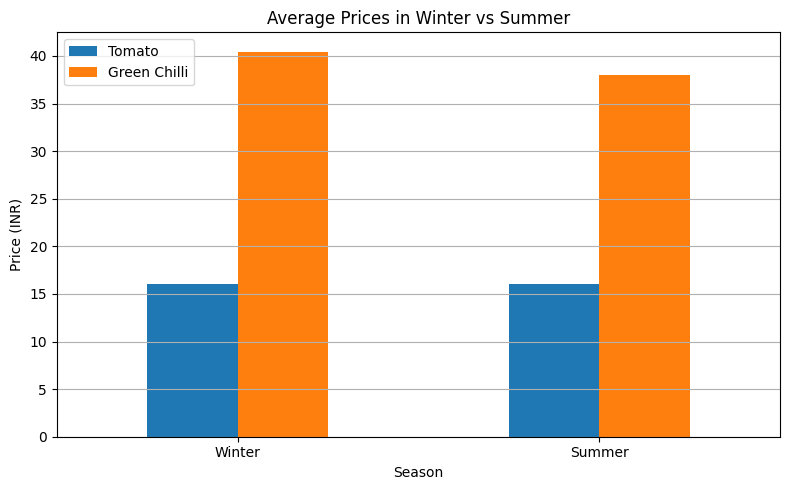

In [19]:

seasonal_means = df_cleaned.groupby('Season')[['Tomato', 'Green Chilli']].mean().round(2)

seasonal_means[['Tomato', 'Green Chilli']].loc[['Winter', 'Summer']].plot(
    kind='bar', figsize=(8, 5), title='Average Prices in Winter vs Summer'
)
plt.ylabel("Price (INR)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [46]:
# Show all column names in summer_df
print(summer_df.columns)
df_cleaned.head()  


Index(['Price Dates', 'Bhindi (Ladies finger)', 'Tomato', 'Onion', 'Potato',
       'Brinjal', 'Garlic', 'Peas', 'Methi', 'Green Chilli',
       'Elephant Yam (Suran)', 'Month', 'Season'],
      dtype='object')


,Price Dates,Bhindi (Ladies finger),Tomato,Onion,Potato,Brinjal,Garlic,Peas,Methi,Green Chilli,Elephant Yam (Suran),Month,Season
0,2023-01-01,35.0,18,22.0,20,30,50,25,8,45.0,25,1,Summer
1,2023-01-02,35.0,16,22.0,20,30,55,25,7,40.0,25,1,Summer
2,2023-01-03,35.0,16,21.0,20,30,55,25,7,40.0,25,1,Summer
3,2023-01-04,30.0,16,21.0,22,25,55,25,7,40.0,25,1,Summer
4,2023-01-08,35.0,16,20.0,21,25,55,22,6,35.0,25,1,Summer


<h3> Volatility of Cross-Veg</h3>
<p>   • Day-to-day price volatility of Potato & Tomato.
</p>

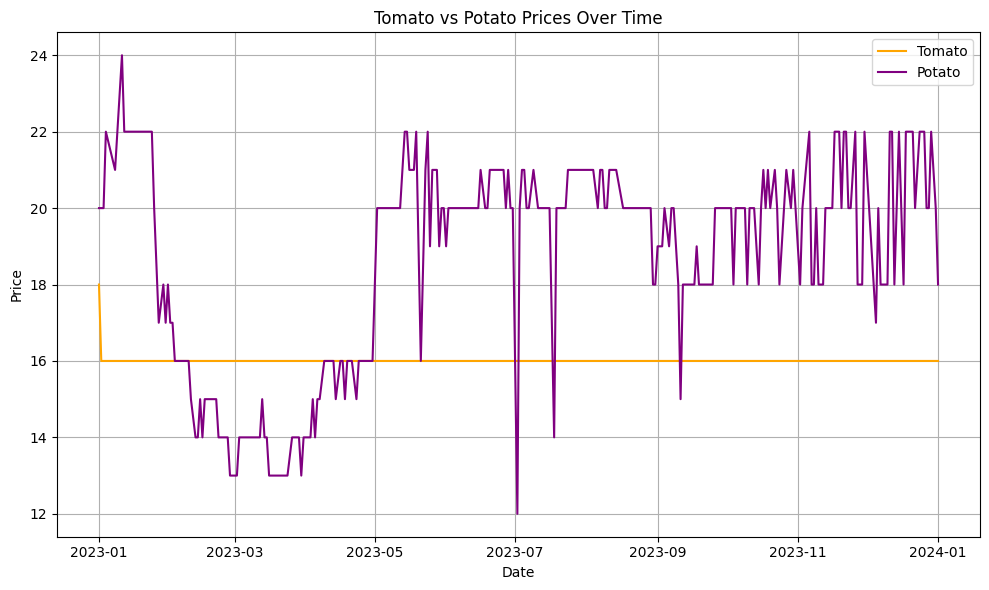

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Price Dates'], df_cleaned['Tomato'], label='Tomato', color='orange')
plt.plot(df_cleaned['Price Dates'], df_cleaned['Potato'], label='Potato', color='purple')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tomato vs Potato Prices Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate daily price changes
tomato_changes = df_cleaned['Tomato'].diff()
potato_changes = df_cleaned['Potato'].diff()

# Calculate standard deviation (volatility)
tomato_volatility = tomato_changes.std()
potato_volatility = potato_changes.std()

print(f"Tomato daily price volatility (std): {tomato_volatility:.2f}")
print(f"Potato daily price volatility (std): {potato_volatility:.2f}")

print(f"Therefore,")
if tomato_volatility > potato_volatility:
    print("Tomato has higher day-to-day price volatility than Potato.")
else:
    print("Potato has higher day-to-day price volatility than Tomato.")

Tomato daily price volatility (std): 0.12
Potato daily price volatility (std): 1.53
Therefore,
Potato has higher day-to-day price volatility than Tomato.


**Potato**: Tends to have more stable supply chains due to better storability and longer shelf life.

**Tomato**: More perishable, highly seasonal, and sensitive to weather conditions, which often leads to frequent price spikes or drops.

<h3>Cross-Veg Correlation</h3>
<p>   • Onion and Garlic prices are positively correlated (r > 0.7) due to shared storage and transport factors.
</p>

Correlation coefficient of Onion and Garlic: 0.76


C:\Users\Bulelwa\AppData\Local\Temp\ipykernel_19544\2798993401.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


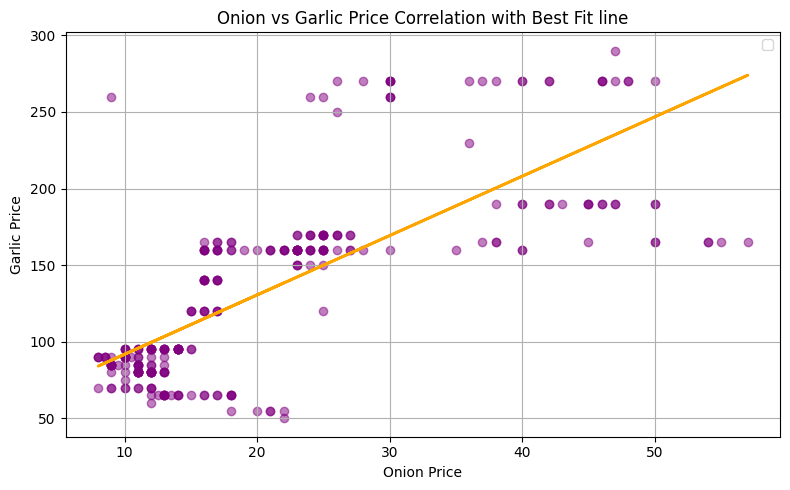

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaNs for fitting
x = df_cleaned['Onion'].dropna()
y = df_cleaned['Garlic'].dropna()
# Align indices
x, y = x.align(y, join='inner')

# Calculate correlation
correlation = df_cleaned['Onion'].corr(df_cleaned['Garlic'])
print(f"Correlation coefficient of Onion and Garlic: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.5, color='purple')

# Line of best fit
coeffs = np.polyfit(x, y, 1)
fit_fn = np.poly1d(coeffs)
plt.plot(x, fit_fn(x), color='orange', linewidth=2)

plt.xlabel('Onion Price')
plt.ylabel('Garlic Price')
plt.title('Onion vs Garlic Price Correlation with Best Fit line')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>Price Spread</h3>
<p>   • The range (max – min) among all vegetables on a given date widens during festivals due to supply surges.
</p>

<h3>Weekend Premium</3>

<p>   • Average modal prices across all veggies are 5–10% higher on weekends vs. weekdays.
</p>